# Customer Segmentation by Personality Through Twitter Analysis

Can we predict personality through the way people write?

The goal of this project is to attempt to segment customers according to personality type by analyzing their twitter posts using Natural Language Processing and several classification models. After building the model, attempts are made to predict the personality type of celebrities through their famous quotes.

The dataset used for this notebook is from Kaggle.com from the following link: https://www.kaggle.com/datasnaek/mbti-type

The Personality System used in this notebook is the Myers-Briggs Type Indicator (MBTI). Information about the MBTI can be found on this link: https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/. The MBTI system divides personalities into 16 different types, all of which are included in this dataset. 

Every personality type consists of 4 letters, each representing a feature of the person as follows:

First Letter: I for Introversion or E for Extroversion

Second Letter: S for Sensing or N for Intuitive

Third Letter: T for Thinking or F for Feeling

Fourth Letter: J for Judging or P for Feeling

In this notebook, we also use a development on the MBTI system called the Keirsey Temperament Sorter which groups the 16 personalities into 4 groups. Information on this system can be found on https://keirsey.com/temperament-overview/.

The Keirsey Temperament Sorter groups the above 16 personalities as follows:

If a person has N and T, this person is a rational.

If a person has N and F, this person is an idealist.

If a person has S and J, this person is a guardian.

If a person has S and P, this person is an artisan.

The content of this notebook is as follows:

1. Data Loading

2. Text Cleaning and Normalization

3. Building Initial Predictive Models

4. Balancing the Datasets

5. Building Models with Balanced Datasets

6. Testing on celebrity quotes

7. Conclusion

# Data Loading

Let us load the data and have a quick look.

In [2]:
# Loading the needed Libraries
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')

data_types = pd.read_csv('mbti_1.csv')
data_types.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In the dataset, each row represents one person. The 'type' column shows this person's personality type, and the 'posts' column shows all the posts tweeted by this person.

# Text Cleaning and Normalization

Now, in this notebook we will divide this dataset into 5 different data frames. So it is important to start by cleaning the text and doing feature extraction at this point instead of repeating it 5 times later.

Let's look at a sample of the text in the posts and see what Natural Language Processing Tools we can use.

In [3]:
data_types.loc[0,'posts'][0:1000]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

First we see that the tweets are separated by a ||| symbol. Second thing to notice is that there are a lot of links included.

Let's remove the links, punctuation, seperators and make all letters lowercase.

In [4]:
from string import punctuation
import re

# remove punctuation function
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

# Remove URL's and the ||| separators
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

for row in range(0,len(data_types)):
    
    # Remove URL's
    data_types.loc[row, 'posts'] = pattern.sub(' ', data_types.loc[row, 'posts'])
        
    # Replace tweet seperator with space
    data_types.loc[row, 'posts'] = data_types.loc[row, 'posts'].replace('|||',' ')
        
    # remove punctuation
    data_types.loc[row, 'posts'] = strip_punctuation(data_types.loc[row,'posts'])
        
    # make lowercase
    data_types.loc[row, 'posts'] = data_types.loc[row, 'posts'].lower()
    
    # Remove numbers
    data_types.loc[row, 'posts'] = ''.join([i for i in data_types.loc[row, 'posts'] if not i.isdigit()])
    
    # Compress large spaces into single spaces
    data_types.loc[row, 'posts'] = ' '.join(data_types.loc[row, 'posts'].split())


Let's take a look at the changes in the text

In [5]:
data_types.loc[0,'posts'][0:1000]

'enfp and intj moments sportscenter not top ten plays pranks what has been the most lifechanging experience in your life on repeat for most of today may the perc experience immerse you the last thing my infj friend posted on his facebook before committing suicide the next day rest in peace hello enfj sorry to hear of your distress its only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard times as times of growth as welcome and stuff game set match prozac wellbrutin at least thirty minutes of moving your legs and i dont mean moving them while sitting in your same desk chair weed in moderation maybe try edibles as a healthier alternative basically come up with three items youve determined that each type or whichever types you want to do would more than likely use given each types cognitive functions and whatnot when left by all things in moderation sims is indeed a video game and a good one at that note a good one at that is

Next, let's Tokenize, remove stop words and apply the Porter Stemmer

In [6]:
# Tokenizing
from nltk.tokenize import word_tokenize
for row in range(0,len(data_types)):
    data_types.loc[row, 'posts'] = word_tokenize(data_types.loc[row, 'posts'])

In [7]:
# Removing stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

for row in range(0,len(data_types)):
    # Remove stopwords
    data_types.loc[row, 'posts'] = [w for w in data_types.loc[row, 'posts'] if not w in stop]

In [8]:
# Stemming
from nltk.stem.porter import PorterStemmer   
porter = PorterStemmer()

for row in range(0,len(data_types)):
    data_types.loc[row, 'posts'] = [porter.stem(word) for word in data_types.loc[row, 'posts']]

In [9]:
# Concatenate list to text again
for row in range(0,len(data_types)):
    data_types.loc[row, 'posts'] = ' '.join(data_types.loc[row, 'posts'])

In [10]:
data_types.loc[0,'posts'][0:1000]

'enfp intj moment sportscent top ten play prank lifechang experi life repeat today may perc experi immers last thing infj friend post facebook commit suicid next day rest peac hello enfj sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg dont mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item youv determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear enfp favorit video game grow current favorit video game cool appear late sad there someon everyon wait thought confid good thing cherish time solitud bc revel within inner world wherea time id workin enjoy time dont worri peopl alway around yo entp ladi your complimentari personalitywel hey main social outlet xbox live convers even verbal 

Now that we've processed the text, let's check the labels of the dataset. We will start by looking at the frequency of each personality type.

Text(0,0.5,'Frequency')

Text(0.5,0,'Types')

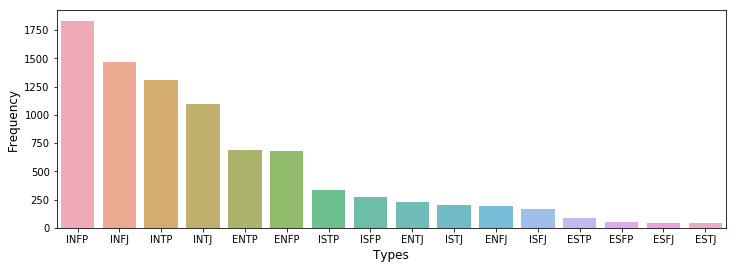

In [11]:
type_counts = data_types['type'].value_counts()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
sns.barplot(type_counts.index, type_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

It seems that there is a huge variation in the frequencies of different personality types in the dataset. We are not sure how the dataset was collected but the low frequency of the letter S can be attributed to the nature of the Sensing person who is more interested in the here-and-now, and would be less likely interested in participating in a research to find hidden patterns of personality.

Let us also create a new dataframe that groups together the personalities according to the Keirsey Temperament Sorter.

In [12]:
col_names =  ['type', 'posts', 'label']
data_temperament = pd.DataFrame(columns = col_names)
data_temperament.type = data_types.type
data_temperament.posts = data_types.posts
data_temperament.temperament = ""

for row in range(0,len(data_temperament)):
    
    if data_types.loc[row,'type'] in ('INFJ', 'INFP', 'ENFJ', 'ENFP'):
        data_temperament.loc[row,'label'] = 'idealist'
    
    if data_types.loc[row,'type'] in ('INTJ', 'INTP', 'ENTJ', 'ENTP'):
        data_temperament.loc[row,'label'] = 'rational'
    
    if data_types.loc[row,'type'] in ('ISTJ', 'ISFJ', 'ESFJ', 'ESTJ'):
        data_temperament.loc[row,'label'] = 'guardian'
        
    if data_types.loc[row,'type'] in ('ISTP', 'ISFP', 'ESTP', 'ESFP'):
        data_temperament.loc[row,'label'] = 'artisan'
        
data_temperament.head()

,type,posts,label
0,INFJ,enfp intj moment sportscent top ten play prank...,idealist
1,ENTP,im find lack post alarm sex bore posit often e...,rational
2,INTP,good one cours say know that bless curs absolu...,rational
3,INTJ,dear intp enjoy convers day esoter gab natur u...,rational
4,ENTJ,your fire that anoth silli misconcept approach...,rational


Now let us check the frequency of each temperament in the dataset.

idealist    4167
rational    3311
artisan      745
guardian     452
Name: label, dtype: int64

Text(0,0.5,'Frequency')

Text(0.5,0,'Temperament')

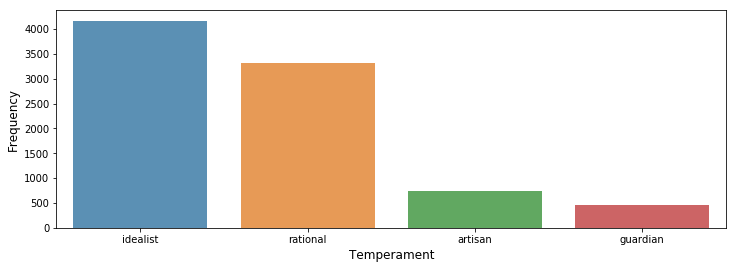

In [13]:
type_counts = data_temperament['label'].value_counts()
type_counts
plt.figure(figsize=(12,4))
sns.barplot(type_counts.index, type_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Temperament', fontsize=12)
plt.show()

There is a severe imbalance in the dataset. Let's check if there are balanced instances of each of the letters.

Let's divide the dataframe into four other dataframes, each for one of the letters.

In [14]:
col_names =  ['type', 'posts', 'I/E', 'S/N', 'T/F', 'J/P']
tmp = pd.DataFrame(columns = col_names)
tmp.type = data_types.type
tmp.posts = data_types.posts

for row in range(0,len(tmp)):
    if tmp.loc[row,'type'][0] == 'I':
        tmp.loc[row,'I/E'] = 'I'
    else:
        tmp.loc[row,'I/E'] = 'E'
    
    if tmp.loc[row,'type'][1] == 'S':
        tmp.loc[row,'S/N'] = 'S'
    else:
        tmp.loc[row,'S/N'] = 'N'
        
    if tmp.loc[row,'type'][2] == 'T':
        tmp.loc[row,'T/F'] = 'T'
    else:
        tmp.loc[row,'T/F'] = 'F'
        
    if tmp.loc[row,'type'][3] == 'J':
        tmp.loc[row,'J/P'] = 'J'
    else:
        tmp.loc[row,'J/P'] = 'P'

tmp.head()


data_types_ie = tmp[['posts', 'I/E']]
data_types_sn = tmp[['posts', 'S/N']]
data_types_tf = tmp[['posts', 'T/F']]
data_types_jp = tmp[['posts', 'J/P']]


,type,posts,I/E,S/N,T/F,J/P
0,INFJ,enfp intj moment sportscent top ten play prank...,I,N,F,J
1,ENTP,im find lack post alarm sex bore posit often e...,E,N,T,P
2,INTP,good one cours say know that bless curs absolu...,I,N,T,P
3,INTJ,dear intp enjoy convers day esoter gab natur u...,I,N,T,J
4,ENTJ,your fire that anoth silli misconcept approach...,E,N,T,J


Let's check the I/E dataframe

,posts,label
0,enfp intj moment sportscent top ten play prank...,I
1,im find lack post alarm sex bore posit often e...,E
2,good one cours say know that bless curs absolu...,I
3,dear intp enjoy convers day esoter gab natur u...,I
4,your fire that anoth silli misconcept approach...,E


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

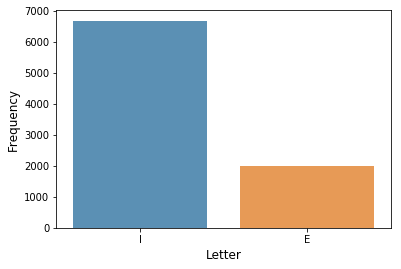

I    6676
E    1999
Name: label, dtype: int64

In [15]:
data_types_ie.columns = ['posts', 'label']
data_types_ie.head()
letter_counts = data_types_ie['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

There is a clear imbalance in the frequency of the I and E. Let's check the S/N column.

,posts,label
0,enfp intj moment sportscent top ten play prank...,N
1,im find lack post alarm sex bore posit often e...,N
2,good one cours say know that bless curs absolu...,N
3,dear intp enjoy convers day esoter gab natur u...,N
4,your fire that anoth silli misconcept approach...,N


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

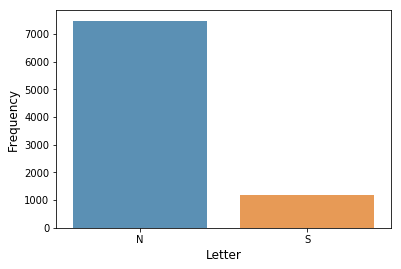

N    7478
S    1197
Name: label, dtype: int64

In [16]:
data_types_sn.columns = ['posts', 'label']
data_types_sn.head()
letter_counts = data_types_sn['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

Huge imbalance between N and S. Next, let's check T and F.

,posts,label
0,enfp intj moment sportscent top ten play prank...,F
1,im find lack post alarm sex bore posit often e...,T
2,good one cours say know that bless curs absolu...,T
3,dear intp enjoy convers day esoter gab natur u...,T
4,your fire that anoth silli misconcept approach...,T


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

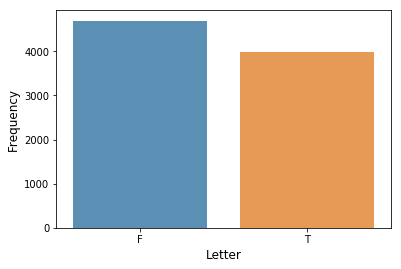

F    4694
T    3981
Name: label, dtype: int64

In [17]:
data_types_tf.columns = ['posts', 'label']
data_types_tf.head()
letter_counts = data_types_tf['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

T and F look much more balanced. Finally, let's look at J and P.

,posts,label
0,enfp intj moment sportscent top ten play prank...,J
1,im find lack post alarm sex bore posit often e...,P
2,good one cours say know that bless curs absolu...,P
3,dear intp enjoy convers day esoter gab natur u...,J
4,your fire that anoth silli misconcept approach...,J


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

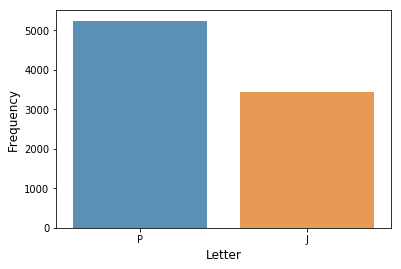

P    5241
J    3434
Name: label, dtype: int64

In [18]:
data_types_jp.columns = ['posts', 'label']
data_types_jp.head()
letter_counts = data_types_jp['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

Slightly unbalanced. P is a little more than half of J.

We will attempt to create the classification models for predicting the letters and temperaments with the datasets like this and check for the accuracy to see if we need to balance them out.

First, let's review the dataframes we have:

- data_types_ie: The Introvert/Extrovert (I/E) column only.

- data_types_sn: The Sensing/Intuition (S/N) column only.

- data_types_tf: The Thinking/Feeling (T/F) column only.

- data_types_jp: The Judging/Perceiving (J/P) column only.

We will build a model for each one of these by itself to predict the personality type.

And finally:

- data_temperament_balanced: The dataframe for personality types grouped into temperament, where we will build a separate model.

We will first create a function to test different classification models and compare the accuracy. We will also use Count Vectorizer and TFIDF for processing the text.

# Building Initial Predictive Models

In [19]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score, cross_val_predict

D:\IE_Software\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
def model_testing(text):
    LSVC = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', LinearSVC(multi_class="ovr"))])
    SGD  = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SGDClassifier())])
    PAC = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-pac', PassiveAggressiveClassifier(max_iter=50))])
    LR = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-lr', LogisticRegression(multi_class="ovr"))])
    NB = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-nb', MultinomialNB())])
    
    LSVC = LSVC.fit(text['posts'], text['label'])
    PAC = PAC.fit(text['posts'], text['label'])
    LR = LR.fit(text['posts'], text['label'])
    NB = NB.fit(text['posts'], text['label'])
    SGD = SGD.fit(text['posts'], text['label'])
    
    acc_table = pd.DataFrame()
    acc_table['model'] = ['Linear SVC', 'Passive Aggressive Classifier', 'Logistic Regression', 'Multinomial Naive Bayes', 'Linear SGD']
    
    acc_table.loc[0,'accuracy'] = np.mean(cross_val_score(LSVC, text['posts'], text['label'], scoring = 'accuracy', cv=8))
    acc_table.loc[1,'accuracy'] = np.mean(cross_val_score(PAC, text['posts'], text['label'], scoring = 'accuracy', cv=8))
    acc_table.loc[2,'accuracy'] = np.mean(cross_val_score(LR, text['posts'], text['label'], scoring = 'accuracy', cv=8))
    acc_table.loc[3,'accuracy'] = np.mean(cross_val_score(NB, text['posts'], text['label'], scoring = 'accuracy', cv=8))
    acc_table.loc[4,'accuracy'] = np.mean(cross_val_score(SGD, text['posts'], text['label'], scoring = 'accuracy', cv=8))

    
    return acc_table

Let's see which model is best for the I/E dataframe.

In [21]:
model_testing(data_types_ie)

,model,accuracy
0,Linear SVC,0.852104
1,Passive Aggressive Classifier,0.834005
2,Logistic Regression,0.841615
3,Multinomial Naive Bayes,0.769568
4,Linear SGD,0.856140


In [22]:
data_types_ie.count()

posts    8675
label    8675
dtype: int64

The best model is the Linear SGD, so we will use it for the I/E prediction.
Let's split the dataset into training and validation to fit the model and look at the confusion matrix

(6940,)

(6940,)

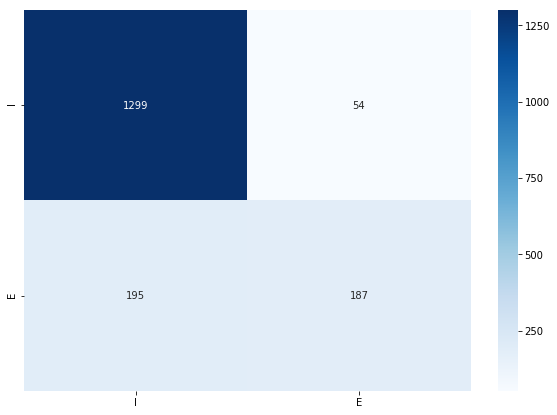

In [24]:
from sklearn.model_selection import train_test_split

# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_ie['posts'], data_types_ie['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model
ie_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SGDClassifier())])
ie_model = ie_model.fit(X_train, y_train)
# Predicting on the validation set
predicted = ie_model.predict(X_val)

import seaborn as sn
conf = confusion_matrix(y_val, predicted, labels=["I", "E"]) 
df_cm = pd.DataFrame(conf, index = ["I", "E"], columns = ["I", "E"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

The accuracy is misleading. The I's are properly predicted, but the E's are not (Nearly 50% are incorrect). This dataset needs to be balanced out.

Now let's test models for S/N dataframe.

In [25]:
model_testing(data_types_sn)

,model,accuracy
0,Linear SVC,0.904555
1,Passive Aggressive Classifier,0.893717
2,Logistic Regression,0.882882
3,Multinomial Naive Bayes,0.862018
4,Linear SGD,0.906169


Linear SVC Classifier gives us the best accuracy and we will use it to build a confusion matrix for S/N prediction.

(6940,)

(6940,)

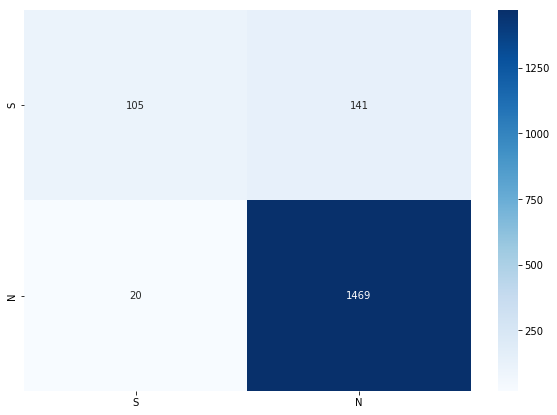

In [26]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_sn['posts'], data_types_sn['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model
sn_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', LinearSVC(multi_class="ovr"))])
sn_model = sn_model.fit(X_train, y_train)
# Predicting on the validation set
predicted = sn_model.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["S", "N"]) 
df_cm = pd.DataFrame(conf, index = ["S", "N"], columns = ["S", "N"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

N's are properly predicted, S's are not (Less than 50%). Therefore, this dataset needs to be balanced out.

Next, the T/F dataframe.

In [27]:
model_testing(data_types_tf)

,model,accuracy
0,Linear SVC,0.847610
1,Passive Aggressive Classifier,0.827552
2,Logistic Regression,0.860520
3,Multinomial Naive Bayes,0.565762
4,Linear SGD,0.857409


Logistic Regression is the winner.

(6940,)

(6940,)

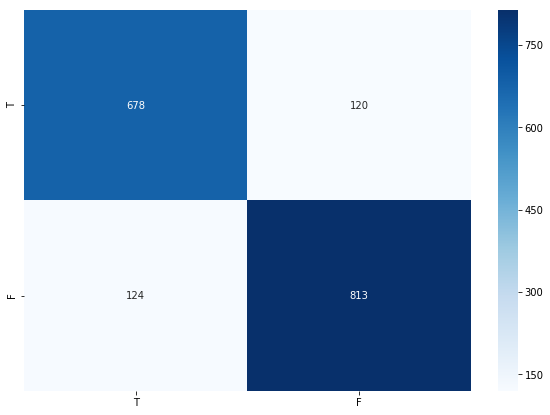

In [28]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_tf['posts'], data_types_tf['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

tf_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-lr', LogisticRegression(multi_class="ovr"))])
tf_model = tf_model.fit(X_train, y_train)
# Predicting on the validation set
predicted = tf_model.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["T", "F"]) 
df_cm = pd.DataFrame(conf, index = ["T", "F"], columns = ["T", "F"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

This model is much better since the T and F are already balanced.

Next, let's check J/P.

In [29]:
model_testing(data_types_jp)

,model,accuracy
0,Linear SVC,0.785705
1,Passive Aggressive Classifier,0.758726
2,Logistic Regression,0.802190
3,Multinomial Naive Bayes,0.604150
4,Linear SGD,0.795388


Much lower accuracy, but again Logistic Regression is the winner.

(6940,)

(6940,)

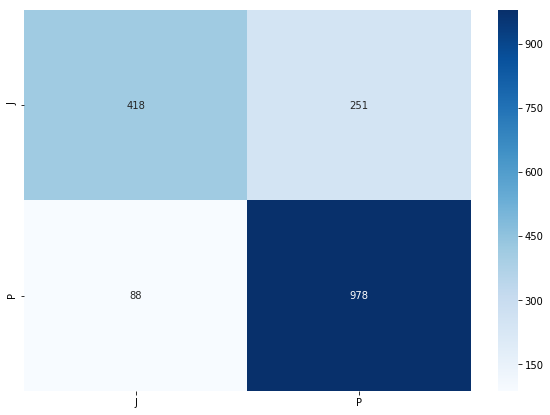

In [30]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_jp['posts'], data_types_jp['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

jp_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-lr', LogisticRegression(multi_class="ovr"))])
jp_model = jp_model.fit(X_train, y_train)

# Predicting on the validation set
predicted = jp_model.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["J", "P"]) 
df_cm = pd.DataFrame(conf, index = ["J", "P"], columns = ["J", "P"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

60% of the J's are predicted correctly. We will therefore try to balance out this dataset.

Finally, our temperament dataframe.

In [31]:
model_testing(data_temperament)

,model,accuracy
0,Linear SVC,0.792970
1,Passive Aggressive Classifier,0.768072
2,Logistic Regression,0.783054
3,Multinomial Naive Bayes,0.484956
4,Linear SGD,0.800347


Linear SGD is the winner.

(6940,)

(6940,)

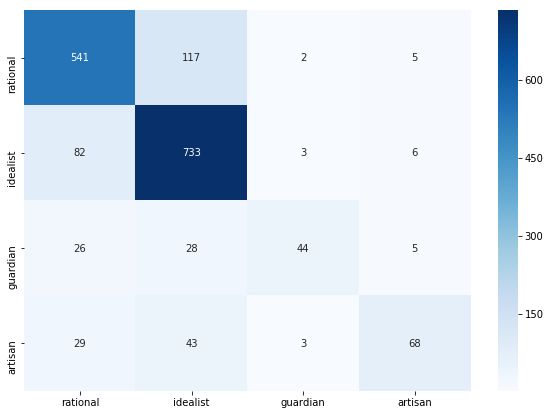

In [32]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_temperament['posts'], data_temperament['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

temperament_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SGDClassifier())])
temperament_model = temperament_model.fit(X_train, y_train)

# Predicting on the validation set
predicted = temperament_model.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["rational", "idealist", "guardian", "artisan"]) 
df_cm = pd.DataFrame(conf, index = ["rational", "idealist", "guardian", "artisan"], columns = ["rational", "idealist", "guardian", "artisan"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Classifying Rational and Idealist is good, and this is expected as there is a lot of training data for it. But classifying artisan and guardian is very bad. We, therefore, need to balance out this dataset as well.

# Balancing the Datasets

We tried building the model with the imbalanced datasets. Let's try balancing the datasets now.

Let's start with the I/E dataset. Let's aim at having 4000 rows of each by duplicating the E's and reducing the I's.

(4000, 2)

(4000, 2)

,posts,label
2,good one cours say know that bless curs absolu...,I
3,dear intp enjoy convers day esoter gab natur u...,I
5,scienc perfect scientist claim scientif inform...,I
6,cant draw nail haha done profession nail ye ge...,I
8,im sure that good question distinct two depend...,I


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

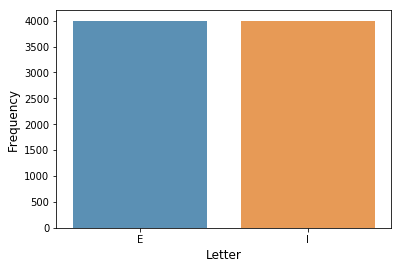

E    4000
I    4000
Name: label, dtype: int64

In [33]:
i = data_types_ie.loc[data_types_ie['label'] == 'I']
e = data_types_ie.loc[data_types_ie['label'] == 'E']

# we remove 2676 rows from the I's
remove_n = 2676
drop_indices = np.random.choice(i.index, remove_n, replace=False)
i = i.drop(drop_indices)

# we add 2001 rows for the E's
e = e.append(e)
e = e.reset_index(drop=True)
add_n = 2
add_indices = np.random.choice(e.index, add_n, replace=True)
e = e.append(e.loc[add_indices])

i.shape
e.shape

data_types_ie_balanced = i
data_types_ie_balanced = data_types_ie_balanced.append(e)

data_types_ie_balanced.head()
letter_counts = data_types_ie_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

Now the I/E dataframe is balanced, let's do the same same with the others.

For the S/N dataframe, let's aim to have 3000 rows for each.

(3000, 2)

(3000, 2)

,posts,label
0,paint without number id guess istp best bud es...,S
1,got ive read enneagram im though read somewher...,S
2,love feel affection one love care care deepli ...,S
3,im current root around forum look place rant t...,S
4,true sadli mani felt like particip itunsur cou...,S


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

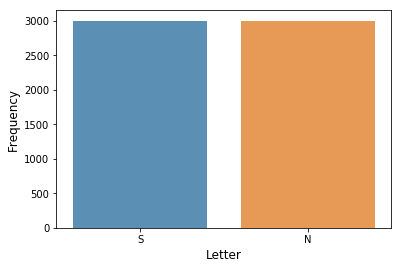

S    3000
N    3000
Name: label, dtype: int64

In [34]:
s = data_types_sn.loc[data_types_sn['label'] == 'S']
n = data_types_sn.loc[data_types_sn['label'] == 'N']

# we remove 4478 rows from the N's
remove_n = 4478
drop_indices = np.random.choice(n.index, remove_n, replace=False)
n = n.drop(drop_indices)

# we add 1803 rows for the E's
s = s.append(s)
s = s.reset_index(drop=True)
add_n = 606
add_indices = np.random.choice(s.index, add_n, replace=True)
s = s.append(s.loc[add_indices])

s.shape
n.shape

data_types_sn_balanced = s
data_types_sn_balanced = data_types_sn_balanced.append(n)

data_types_sn_balanced.head()
letter_counts = data_types_sn_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

We can leave the T/F column without balancing since there are enough instances from both.

Finally, let's balance the J/P dataframe. Let's aim at having 3434 rows, which the current number of J's. So we just need to remove 1807 from the P's.

(3434, 2)

(3434, 2)

,posts,label
0,enfp intj moment sportscent top ten play prank...,J
3,dear intp enjoy convers day esoter gab natur u...,J
4,your fire that anoth silli misconcept approach...,J
5,scienc perfect scientist claim scientif inform...,J
6,cant draw nail haha done profession nail ye ge...,J


Text(0,0.5,'Frequency')

Text(0.5,0,'Letter')

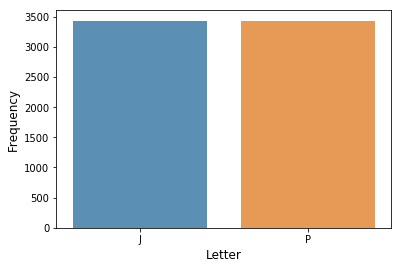

J    3434
P    3434
Name: label, dtype: int64

In [35]:
j = data_types_jp.loc[data_types_jp['label'] == 'J']
p = data_types_jp.loc[data_types_jp['label'] == 'P']

# we remove 1807 rows from the P's
remove_n = 1807
drop_indices = np.random.choice(p.index, remove_n, replace=False)
p = p.drop(drop_indices)

p.shape
j.shape

data_types_jp_balanced = j
data_types_jp_balanced = data_types_jp_balanced.append(p)

data_types_jp_balanced.head()
letter_counts = data_types_jp_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(letter_counts.index, letter_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Letter', fontsize=12)
plt.show()
letter_counts

Balancing the Temperament Dataset. We will aim at having 1000 persons from every temperament.

(4000, 3)

Text(0,0.5,'Frequency')

Text(0.5,0,'Temperament')

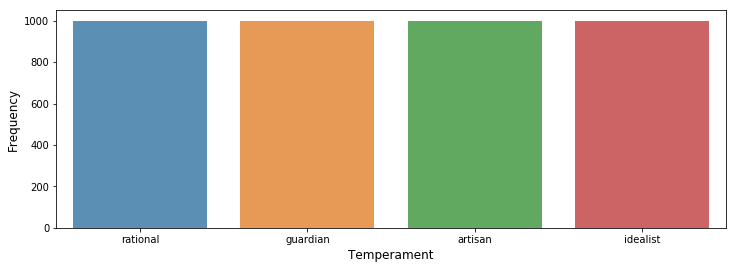

In [36]:
idealists = data_temperament.loc[data_temperament['label'] == 'idealist']
guardians = data_temperament.loc[data_temperament['label'] == 'guardian']
rationals = data_temperament.loc[data_temperament['label'] == 'rational']
artisans = data_temperament.loc[data_temperament['label'] == 'artisan']
np.random.seed(10)

# For idealists we remove 3167 rows
remove_n = 3167
drop_indices = np.random.choice(idealists.index, remove_n, replace=False)
idealists = idealists.drop(drop_indices)

# For rationals we remove 2311 rows
remove_n = 2311
drop_indices = np.random.choice(rationals.index, remove_n, replace=False)
rationals = rationals.drop(drop_indices)

# For guardians we duplicate the rows then add another 96
guardians = guardians.append(guardians)
guardians = guardians.reset_index(drop=True)
add_n = 96
add_indices = np.random.choice(guardians.index, add_n, replace=True)
guardians = guardians.append(guardians.loc[add_indices])

# For artisans we remove 490 rows
artisans = artisans.append(artisans)
artisans = artisans.reset_index(drop=True)
remove_n = 490
drop_indices = np.random.choice(artisans.index, remove_n, replace=False)
artisans = artisans.drop(drop_indices)


data_temperament_balanced = idealists
data_temperament_balanced = data_temperament_balanced.append(rationals)
data_temperament_balanced = data_temperament_balanced.append(guardians)
data_temperament_balanced = data_temperament_balanced.append(artisans)
data_temperament_balanced = data_temperament_balanced.reset_index(drop=True)

data_temperament_balanced.shape

type_counts = data_temperament_balanced['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(type_counts.index, type_counts.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Temperament', fontsize=12)
plt.show()

Let's build the classification models once more as we did previously, but this time with the balanced datasets.

# Building Models with Balanced Datasets

Let's see which model is best for the I/E dataframe.

In [37]:
model_testing(data_types_ie_balanced)

,model,accuracy
0,Linear SVC,0.925125
1,Passive Aggressive Classifier,0.928750
2,Logistic Regression,0.861500
3,Multinomial Naive Bayes,0.842875
4,Linear SGD,0.896500


The best model is the Passive Aggressive Classifier, so we will use it for the I/E prediction.

(6400,)

(6400,)

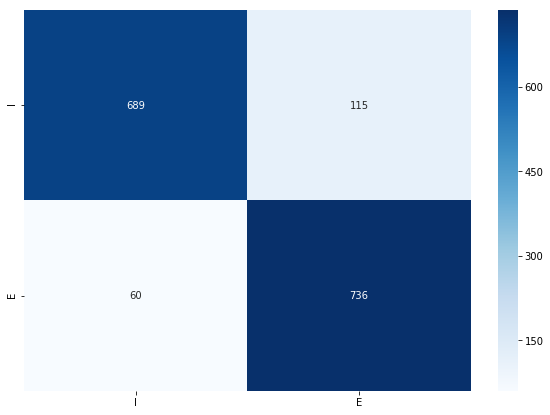

In [38]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_ie_balanced['posts'], data_types_ie_balanced['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

ie_model_balanced = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-pac', PassiveAggressiveClassifier(max_iter=50))])
ie_model_balanced = ie_model_balanced.fit(X_train, y_train)

# Predicting on the validation set
predicted = ie_model_balanced.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["I", "E"]) 
df_cm = pd.DataFrame(conf, index = ["I", "E"], columns = ["I", "E"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

E's are much better predicted than before, but it is very important to note that part of this high accuracy for the E is that the rows are duplicated so it's much easier to classify them.

Now let's test models for S/N dataframe.

In [39]:
model_testing(data_types_sn_balanced)

,model,accuracy
0,Linear SVC,0.944500
1,Passive Aggressive Classifier,0.950833
2,Logistic Regression,0.901000
3,Multinomial Naive Bayes,0.901333
4,Linear SGD,0.936500


Once again, the Passive Aggressive Classifier gives us the best accuracy and is our chosen model for S/N prediction.

(4800,)

(4800,)

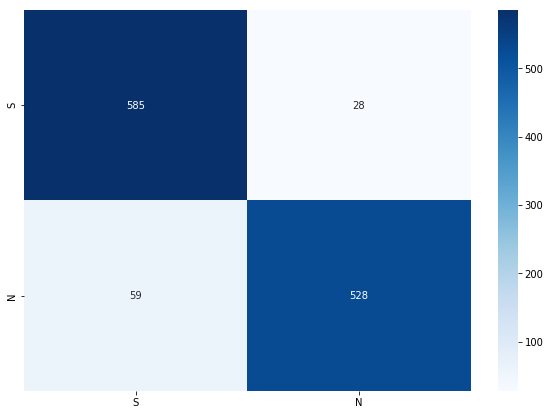

In [40]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_sn_balanced['posts'], data_types_sn_balanced['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

sn_model_balanced = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-pac', PassiveAggressiveClassifier(max_iter=50))])
sn_model_balanced = sn_model_balanced.fit(X_train, y_train)

# Predicting on the validation set
predicted = sn_model_balanced.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["S", "N"]) 
df_cm = pd.DataFrame(conf, index = ["S", "N"], columns = ["S", "N"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Much better prediction for the S, but again it is important to remember that it is partly caused by the duplication in the rows.

We will skip the T/F dataframe.

Next, let's check J/P.

In [41]:
model_testing(data_types_jp_balanced)

,model,accuracy
0,Linear SVC,0.772128
1,Passive Aggressive Classifier,0.744753
2,Logistic Regression,0.796157
3,Multinomial Naive Bayes,0.690442
4,Linear SGD,0.779114


Much lower accuracy, but again Logistic Regression is the winner.

(5494,)

(5494,)

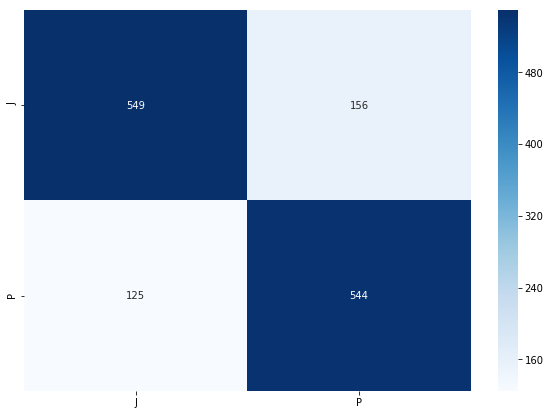

In [42]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_types_jp_balanced['posts'], data_types_jp_balanced['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

jp_model_balanced = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-lr', LogisticRegression(multi_class="ovr"))])
jp_model_balanced = jp_model_balanced.fit(X_train, y_train)

# Predicting on the validation set
predicted = jp_model_balanced.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["J", "P"]) 
df_cm = pd.DataFrame(conf, index = ["J", "P"], columns = ["J", "P"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Much better prediction for the J. But the general lower accuracy of the models makes us conclude that it seems that J and P do not show in a person's writing as much as the other letters.

Finally, our temperament dataframe.

In [43]:
model_testing(data_temperament_balanced)

,model,accuracy
0,Linear SVC,0.86675
1,Passive Aggressive Classifier,0.86125
2,Logistic Regression,0.83175
3,Multinomial Naive Bayes,0.76350
4,Linear SGD,0.86150


Linear SVC is the winner.

(3200,)

(3200,)

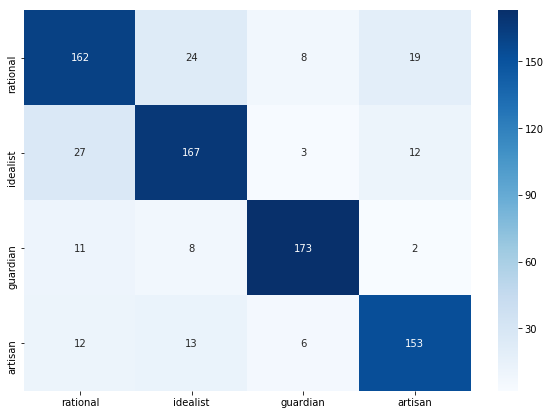

In [44]:
# create training and validation vars
X_train, X_val, y_train, y_val = train_test_split(data_temperament_balanced['posts'], data_temperament_balanced['label'], test_size=0.2, random_state=42)
X_train.shape
y_train.shape

# Fitting the Model

temperament_model_balanced = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', LinearSVC(multi_class="ovr"))])
temperament_model_balanced = temperament_model_balanced.fit(X_train, y_train)

# Predicting on the validation set
predicted = temperament_model_balanced.predict(X_val)

conf = confusion_matrix(y_val, predicted, labels=["rational", "idealist", "guardian", "artisan"]) 
df_cm = pd.DataFrame(conf, index = ["rational", "idealist", "guardian", "artisan"], columns = ["rational", "idealist", "guardian", "artisan"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Results are much better for guardians and artisans.

# How can we use these models?

Being able to identify a user's personality preferences can be very beneficial for customer segmentation in order to design marketing messages that are relevant to the users. 

Here are some sample marketing messages for each temperament and letter:

For the Temperaments:

Rationals: Our product will provide statistically significant improvements to your efficiency.

Idealists: Our product will help you change the world.

Guardians: Our product has always been the reliable number one choice.

Artisans: Our product is what you need right now to get it done.


For the Inidividual Letters, N/S and T/F might perhaps be the ones with the most effect on marketing messages:

Intuitive (N) - a more abstract message: In the forest of life, our product helps you be the lion.

Sensing (S) - a more concrete message: Our product is easier to apply, maintain and gives better results.

Thinking (T) - a more factual message: Why Us? Our product fulfills your needs.

Feeling (F) - a more emotional message: Why Us? Our team cares for you.




# Can we Generalize the Models? Testing on Celebrity Quotes

We will test the models on a corpus of quotes of famous people found on Github (https://github.com/alvations/Quotables).
This quotes file was filtered and the personality types of each person was added according to the following links:
https://legacy.keirsey.com/4temps/famous_guardians.asp
https://legacy.keirsey.com/4temps/famous_artisans.asp
https://legacy.keirsey.com/4temps/famous_rational.asp
https://legacy.keirsey.com/4temps/famous_idealists.asp

We will use this file to explore whether we can use our models that were built from tweets to predict the personality types from quotes.

In [45]:
quotes = pd.read_csv('quotes2.csv')
quotes.head()
quotes.shape
quotes.quotes = quotes.quotes.astype(str)

,person,temperament,ie,sn,tf,jp,quotes
0,Abraham Lincoln,rational,E,N,T,P,Always bear in mind that your own resolution t...
1,Albert Einstein,rational,I,N,T,P,You have to learn the rules of the game. And t...
2,Albert Schweitzer,idealist,I,N,F,P,"In everyone's life, at some time, our inner fi..."
3,Aldous Huxley,idealist,I,N,F,P,Experience is not what happens to you; it's wh...
4,Alexander Hamilton,idealist,E,N,F,P,Those who stand for nothing fall for anything....


(65, 7)

We will process the quotes in the same way we processed the tweets before, then use our models (with the balanced datasets) to predict the personality types.

In [46]:
test_text = quotes

# Remove punctuation function
from string import punctuation

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)


for row in range(0,len(test_text)):
    
    # remove punctuation
    test_text.loc[row, 'quotes'] = strip_punctuation(test_text.loc[row,'quotes'])
        
    # make lowercase
    test_text.loc[row, 'quotes'] = test_text.loc[row, 'quotes'].lower()
    
    # Remove numbers
    test_text.loc[row, 'quotes'] = ''.join([i for i in test_text.loc[row, 'quotes'] if not i.isdigit()])
    
    # Compress large spaces into single spaces
    test_text.loc[row, 'quotes'] = ' '.join(test_text.loc[row, 'quotes'].split())

   
    
# Tokenizing

for row in range(0,len(test_text)):
    test_text.loc[row, 'quotes'] = word_tokenize(test_text.loc[row, 'quotes'])
    
# Remove stop words
stop = set(stopwords.words('english'))

for row in range(0,len(test_text)):
    test_text.loc[row, 'quotes'] = [w for w in test_text.loc[row, 'quotes'] if not w in stop]
    
# Stemming
for row in range(0,len(test_text)):
    porter = PorterStemmer()
    test_text.loc[row, 'quotes'] = [porter.stem(word) for word in test_text.loc[row, 'quotes']]


# Concatenate list to text again
for row in range(0,len(test_text)):
    test_text.loc[row, 'quotes'] = ' '.join(test_text.loc[row, 'quotes'])
    
test_text.loc[0,'quotes'][0:1000]

'alway bear mind resolut succeed import end year life count life year nearli men stand advers want test man charact give power folk happi make mind america never destroy outsid falter lose freedom destroy best thing futur come one day time hope owe angel mother escap respons tomorrow evad today philosophi school room one gener philosophi govern next charact like tree reput like shadow shadow think tree real thing give six hour chop tree spend first four sharpen axe bound win bound true bound succeed bound live light must stand anybodi stand right stand right part goe wrong better remain silent thought fool speak remov doubt whatev good one good feel good bad feel bad that religion fool peopl time peopl time fool peopl time four score seven year ago father brought forth contin new nation conceiv liberti dedic proposit men creat equal man good enough govern anoth man without other consent marriag neither heaven hell simpli purgatori thing may come wait thing left hustl dont worri recogn 

Now let's fit the models and analyze the results.

We will predict the temperament using two ways:
1. Using the predicted letters where N & T result in Rational, N & F result in Idealist, S & J result in Guardian, and S & P result in Artisan. We will call that: Resulting Temperament.
2. Using our temperament model. We will call that Predicted Temperament.

This will give us an idea of which one gives a better prediction.

In [48]:
cols = ['person', 'I/E', 'S/N', 'T/F', 'J/P', 'resulting temperament', 'pred temperament', 'real temperament']
predictions = pd.DataFrame(columns = cols)
predictions['person'] = test_text['person']
predictions['I/E'] = ie_model_balanced.predict(test_text['quotes'])
predictions['S/N'] = sn_model_balanced.predict(test_text['quotes'])
predictions['T/F'] = tf_model.predict(test_text['quotes'])
predictions['J/P'] = jp_model_balanced.predict(test_text['quotes'])
predictions['pred temperament'] = temperament_model_balanced.predict(test_text['quotes'])
predictions['real temperament'] = quotes['temperament']



for row in range(0,len(predictions)):
    if predictions.loc[row,'S/N'] == 'N' and predictions.loc[row,'T/F'] == 'T':
        predictions.loc[row,'resulting temperament'] = 'rational'

    if predictions.loc[row,'S/N'] == 'N' and predictions.loc[row,'T/F'] == 'F':
        predictions.loc[row,'resulting temperament'] = 'idealist'
        
    if predictions.loc[row,'S/N'] == 'S' and predictions.loc[row,'J/P'] == 'J':
        predictions.loc[row,'resulting temperament'] = 'guardian'
        
    if predictions.loc[row,'S/N'] == 'S' and predictions.loc[row,'J/P'] == 'P':
        predictions.loc[row,'resulting temperament'] = 'artisan'


print("Resulting Temperament Accuracy: ", np.mean(predictions['resulting temperament'] == test_text['temperament']))
print("Predicted Temperament Accuracy: ", np.mean(predictions['pred temperament'] == test_text['temperament']))
print("IE Accuracy: " , np.mean(predictions['I/E'] == test_text['ie']))
print("SN Accuracy: " , np.mean(predictions['S/N'] == test_text['sn']))
print("TF Accuracy: " , np.mean(predictions['T/F'] == test_text['tf']))
print("JP Accuracy: " , np.mean(predictions['J/P'] == test_text['jp']))

pd.set_option('display.max_rows', None)
predictions

Resulting Temperament Accuracy:  0.4461538461538462
Predicted Temperament Accuracy:  0.4153846153846154
IE Accuracy:  0.5384615384615384
SN Accuracy:  0.6
TF Accuracy:  0.7384615384615385
JP Accuracy:  0.6


,person,I/E,S/N,T/F,J/P,resulting temperament,pred temperament,real temperament
0,Abraham Lincoln,I,N,F,P,idealist,idealist,rational
1,Albert Einstein,I,N,T,P,rational,rational,rational
2,Albert Schweitzer,I,N,F,J,idealist,idealist,idealist
3,Aldous Huxley,I,N,T,J,rational,rational,idealist
4,Alexander Hamilton,I,N,T,J,rational,rational,idealist
5,Benjamin Franklin,I,N,T,J,rational,idealist,rational
6,Bill Gates,E,N,T,J,rational,rational,rational
7,Bob Dylan,I,N,T,P,rational,idealist,artisan
8,Buddha,I,N,F,J,idealist,idealist,idealist
9,Carl Jung,I,N,F,P,idealist,idealist,idealist


The results don't look good. Let's explore the confusion matrices.

array([[31,  1],
       [29,  4]], dtype=int64)

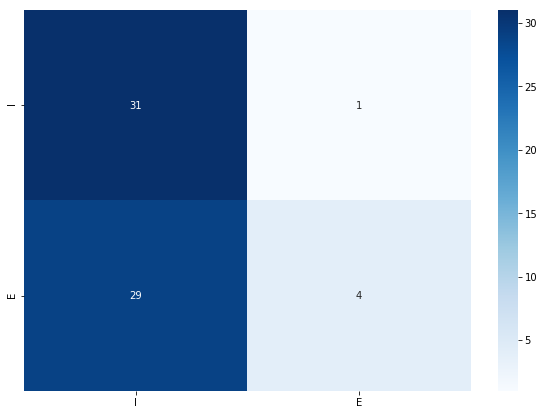

In [49]:
conf = confusion_matrix(test_text['ie'], predictions['I/E'], labels=["I", "E"]) 
conf
df_cm = pd.DataFrame(conf, index = ["I", "E"], columns = ["I", "E"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

The I's are over-predicted. Actually nearly all of the dataset is classified as I. We can probably deduce that this is caused by the overwhelmingly small number of E's in the original dataset. Even duplicating the E rows didn't help here.

array([[ 1, 26],
       [ 0, 38]], dtype=int64)

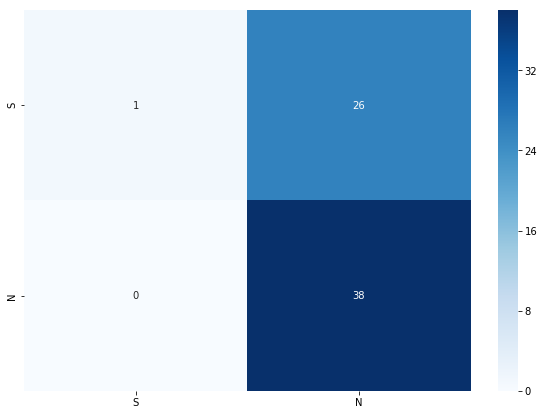

In [50]:
conf = confusion_matrix(test_text['sn'], predictions['S/N'], labels=["S", "N"]) 
conf
df_cm = pd.DataFrame(conf, index = ["S", "N"], columns = ["S", "N"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

We have the same problem. The N's are over-predicted, and this is probably caused by the very low number of S rows in the training data, which gives us fewer training patterns to find.

array([[29,  8],
       [ 9, 19]], dtype=int64)

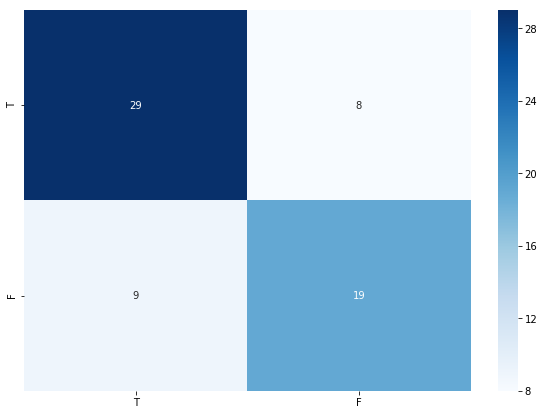

In [51]:
conf = confusion_matrix(test_text['tf'], predictions['T/F'], labels=["T", "F"]) 
conf
df_cm = pd.DataFrame(conf, index = ["T", "F"], columns = ["T", "F"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

78% of T's are correctly identified, while 68% of the F's are correctly identified. There is some classification happening and it is better in predicting the T's. In the original data, the F's were actually more than the T's. This tells us that, while close, there are differences in which Thinking and Feeling traits show up in the training tweets and the celebrity quotes.

array([[17, 14],
       [12, 22]], dtype=int64)

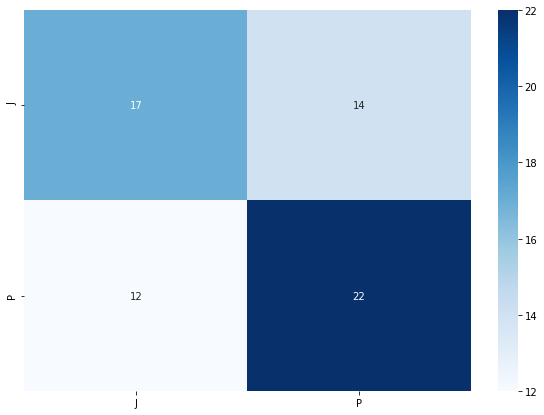

In [52]:
conf = confusion_matrix(test_text['jp'], predictions['J/P'], labels=["J", "P"]) 
conf
df_cm = pd.DataFrame(conf, index = ["J", "P"], columns = ["J", "P"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

55% for correctly predicting J's, and 65% for P's. We said earlier that there seems to be little indication that J or P appear in the text, and this might be the cause here. The results are luke-warm, some are classified correctly but a lot of correct predictions are missed.

array([[15,  3,  0,  0],
       [ 8, 12,  0,  0],
       [ 8,  1,  0,  0],
       [10,  6,  2,  0]], dtype=int64)

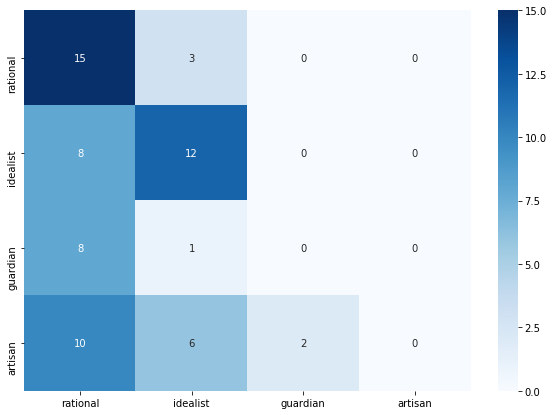

In [53]:
conf = confusion_matrix(test_text['temperament'], predictions['pred temperament'], labels=["rational", "idealist", "guardian", "artisan"]) 
conf
df_cm = pd.DataFrame(conf, index = ["rational", "idealist", "guardian", "artisan"], columns = ["rational", "idealist", "guardian", "artisan"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

This is the confusion matrix of our temperament model, meaning that this model directly looks at the text and tries to predict temperament. The results are not good. First of all, guardians and artisans are almost never predicted, and we can attribute that to their low frequency in the training set. Rationals are predicted very well and Idealists are fairly predicted but a lot of them are mistaken as rationals.

array([[14,  4,  0,  0],
       [ 6, 14,  0,  0],
       [ 6,  3,  0,  0],
       [11,  6,  0,  1]], dtype=int64)

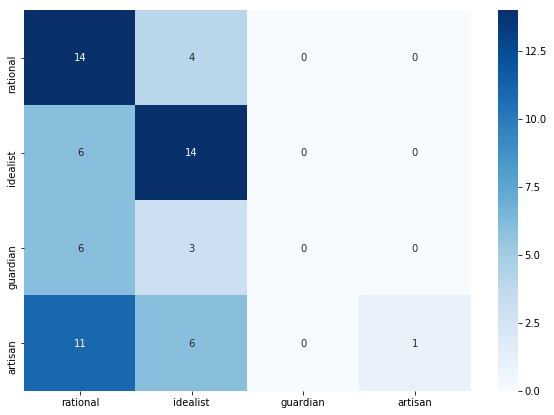

In [54]:
conf = confusion_matrix(test_text['temperament'], predictions['resulting temperament'], labels=["rational", "idealist", "guardian", "artisan"]) 
conf
df_cm = pd.DataFrame(conf, index = ["rational", "idealist", "guardian", "artisan"], columns = ["rational", "idealist", "guardian", "artisan"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

These are the predictions that resulted from combining the individual letters as we described above. The only difference here is that the Idealists are predicted better than before, but we still see an absence in the guardians and artisans. And this is partly because of the low number of training and predicted S's which are common for both guardians and artisans.

# Conclusions

To attempt at answer the original question of this notebook - Can we predict personality from the way people write? - the answer is yes and no.


Why Yes:

- Our original model (with the unbalanced datasets) was correctly predicting the Rationals and Idealists, and this means that there was something in the way people wrote their tweets that pointed to their personality type.


- Thinking and Feeling were also predicted fairly well in our original model, which again tells us that something in how people wrote distinguished this personality preference in them. Predictions from T and F were also fairly good for the quotes from famous people, and that is relevant because the fact that the other models don't work well on the file tells us that there are structural differences between these quotes and the training tweets. And despite this, Thinking and Feeling preferences appear to be distinguishable.


- There are also hints of distinguishable differences between J and P in their original model and in the quotes file, although not as clearly as the others.


Why No:

- People write in different ways according to the context. During the development of this notebook, a quick test was done on the twitter stream of current celebrities using these models, and nearly all of them are showing up as Idealists (some were predicted as rational). While this can be attributed to the high number of idealists and rationals in the training data, it also points to the fact that being an "Idealist" is the image that a lot of celebrities try to make for themselves in this age of political correctness; and many of them are even responsible for awareness campaigns. So the way a famous person would write on twitter, is not the same as how an average person would on his own twitter. And this in turn is not the same as how a person would write in their personal journals or when authoring their book.




What do we need to go forward?
A Balanced Dataset. 

This would at least give us a fair assessment of how well can we predict with our models. There seems to be something we can find, but it might be limited to domain. Meaning that models built with tweets from normal people should be used to classify tweets of other normal people, models built from how an author wrote their book, should be used to classify authors for books,...etc.

But again, the models we built in this notebook tell us that there are indications that personality type can be deduced from the way people write.